In [2]:
# All common imports
import pandas as pd
from sqlalchemy import create_engine
from pathlib import Path

# All common variables
PROJECT_ROOT = Path().resolve().parent
db_file_path = PROJECT_ROOT / 'credit_data.db'
engine = create_engine(f'sqlite:///{db_file_path}')

print("Setup Complete. Engine is ready.")

Setup Complete. Engine is ready.


In [3]:
# Read CSV and write to DB
csv_file_path = PROJECT_ROOT / 'data' / 'loan_approval_dataset.csv'
df = pd.read_csv(csv_file_path)
df.to_sql('loan_data', con=engine, if_exists='replace', index=False)
print("Data loaded to DB.")

Data loaded to DB.


In [4]:
# Read from DB using the engine from the Setup Cell
query = "SELECT * FROM loan_data LIMIT 5"
df_from_db = pd.read_sql(query, con=engine)
display(df_from_db)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
# Load the full table into a pandas DataFrame for analysis.
query_all = "SELECT * FROM loan_data"
df_full = pd.read_sql(query_all, con=engine)

# --- Strip whitespace from all column names ---
df_full.columns = df_full.columns.str.strip()

In [6]:

# --- 1. Remove Unnecessary Columns ---
# The 'loan_id' is just an identifier and provides no predictive value.
# inplace=True means the change is applied directly to the df_full DataFrame.
df_full.drop(columns=['loan_id'], inplace=True)
print("--- 'loan_id' column removed. Updated DataFrame columns: ---")
print(df_full.columns) 

--- 'loan_id' column removed. Updated DataFrame columns: ---
Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')


In [7]:
# --- 2. Analyze the Target Variable: 'loan_status' ---
# .value_counts() counts the number of occurrences of each unique value.
print("\n--- Distribution of the Target Variable (loan_status) ---")
status_counts = df_full['loan_status'].value_counts()
print(status_counts)

# Visualize the distribution with a pie chart for clarity.
import plotly.express as px
fig = px.pie(
    status_counts, 
    values=status_counts.values, 
    names=status_counts.index, 
    title='Loan Status Distribution'
)
fig.show()


--- Distribution of the Target Variable (loan_status) ---
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


In [8]:
# --- Numerical Feature Analysis with Box Plots ---

# 1. CIBIL Score vs. Loan Status
# Using plotly.express for an interactive box plot.
fig_cibil = px.box(
    df_full, 
    x='loan_status', 
    y='cibil_score', 
    color='loan_status',
    title='CIBIL Score Distribution by Loan Status',
    labels={'loan_status': 'Loan Status', 'cibil_score': 'CIBIL Score'}
)
fig_cibil.show()

# 2. Annual Income vs. Loan Status
# We can do the same for annual income.
fig_income = px.box(
    df_full, 
    x='loan_status', 
    y='income_annum', 
    color='loan_status',
    title='Annual Income Distribution by Loan Status',
    labels={'loan_status': 'Loan Status', 'income_annum': 'Annual Income'}
)
fig_income.show()

In [9]:
# --- Categorical Feature Analysis with Bar Charts ---

# 1. Education vs. Loan Status
# Using plotly.express for an interactive bar chart.
# 'count' will be calculated automatically by plotly.
fig_education = px.bar(
    df_full, 
    x='education', 
    color='loan_status', 
    barmode='group', # This creates grouped bars instead of stacked ones.
    title='Loan Status Count by Education Level',
    labels={'education': 'Education Level', 'count': 'Number of Applicants'}
)
fig_education.show()

# 2. Self-Employed vs. Loan Status
# We can do the same for the self-employed status.
fig_self_employed = px.bar(
    df_full, 
    x='self_employed', 
    color='loan_status', 
    barmode='group',
    title='Loan Status Count by Employment Type',
    labels={'self_employed': 'Self-Employed', 'count': 'Number of Applicants'}
)
fig_self_employed.show()

In [10]:
fig = px.histogram(
    df_full,
    x='no_of_dependents',
    color='loan_status',
    barmode='group',
    title='Loan Status by # of Dependents',
    labels={'no_of_dependents':'# of Dependents','count':'Applicants'},
    nbins=df_full['no_of_dependents'].nunique()  # one bin per distinct value
)
fig.update_layout(xaxis_type='category')       # treat 0,1,2… as discrete
fig.show()

In [11]:
dep_rates = (
    df_full
      .groupby('no_of_dependents')['loan_status']
      .value_counts(normalize=True)
      .mul(100)
      .round(1)
      .unstack()
)

print(dep_rates)

loan_status       Approved  Rejected
no_of_dependents                    
0                     64.2      35.8
1                     61.7      38.3
2                     62.3      37.7
3                     62.9      37.1
4                     61.8      38.2
5                     60.3      39.7


In [12]:
# 1) Quick summary of loan_amount
print(df_full['loan_amount'].describe())

# 2) Peek at the first 20 values
print(df_full['loan_amount'].head(20))


count    4.269000e+03
mean     1.513345e+07
std      9.043363e+06
min      3.000000e+05
25%      7.700000e+06
50%      1.450000e+07
75%      2.150000e+07
max      3.950000e+07
Name: loan_amount, dtype: float64
0     29900000
1     12200000
2     29700000
3     30700000
4     24200000
5     13500000
6     33000000
7     15000000
8      2200000
9      4300000
10    11200000
11    22700000
12    11600000
13    31500000
14     7400000
15    10700000
16     1600000
17     9400000
18    10300000
19    14600000
Name: loan_amount, dtype: int64


In [13]:
# 1) Clean up loan_status values by stripping whitespace
df_full['loan_status'] = df_full['loan_status'].str.strip()

# 2) Create 10 equal-width bins for loan_amount (in USD cents → dollars)
df_full['loan_amount'] = df_full['loan_amount'] / 100  # if originally in cents
df_full['amount_bin'] = pd.cut(df_full['loan_amount'], bins=10)

# 3) Count approvals vs. rejections in each bin
counts = (
    df_full
    .groupby(['amount_bin', 'loan_status'])
    .size()
    .unstack(fill_value=0)
)

# 4) Calculate approval rate (%) per bin
counts['approval_rate'] = counts['Approved'] / counts.sum(axis=1) * 100

# 5) Convert each Interval into a human-readable USD label
def format_usd(interval):
    def fmt(x):
        if x >= 1_000_000:
            return f"${x/1_000_000:.1f}M"
        else:
            return f"${int(x/1_000):,}k"
    return f"{fmt(interval.left)}–{fmt(interval.right)}"

# 6) Build DataFrame for plotting
approval_rate = counts.reset_index()[['amount_bin', 'approval_rate']]
approval_rate['bin_label'] = approval_rate['amount_bin'].apply(format_usd)

# 7) Plot approval rate by loan amount bin, with USD indicated
fig = px.bar(
    approval_rate,
    x='bin_label',
    y='approval_rate',
    title='Approval Rate by Loan Amount (USD)',
    labels={
        'bin_label': 'Loan Amount Range (USD)',
        'approval_rate': 'Approval Rate (%)'
    }
)
fig.update_xaxes(tickangle=45, type='category')
fig.show()

/var/folders/m4/yspy02gx60q6pvt0_67nwwc00000gp/T/ipykernel_95769/998848188.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [14]:
fig = px.histogram(
    df_full,
    x='loan_term',
    color='loan_status',
    barmode='group',
    nbins=20,
    title='Loan Term Distribution by Status',
    labels={'loan_term':'Loan Term (months)', 'count':'Applicants'}
)
fig.show()

In [15]:
# 1) Ensure whitespace is stripped
df_full['loan_status'] = df_full['loan_status'].str.strip()

# 2) Calculate approval rate (%) by loan_term
term_counts = (
    df_full
    .groupby(['loan_term', 'loan_status'])
    .size()
    .unstack(fill_value=0)
)
term_counts['approval_rate'] = term_counts['Approved'] / term_counts.sum(axis=1) * 100

# 3) Reset index for plotting
term_rates = term_counts.reset_index()[['loan_term', 'approval_rate']]

# 4) Plot approval rate vs. loan_term
fig = px.line(
    term_rates,
    x='loan_term',
    y='approval_rate',
    markers=True,
    title='Approval Rate by Loan Term',
    labels={'loan_term':'Loan Term (months)', 'approval_rate':'Approval Rate (%)'}
)
fig.update_traces(line=dict(shape='spline'))
fig.show()

In [16]:
fig = px.box(
    df_full,
    x='loan_status',
    y='residential_assets_value',
    title='Residential Assets Value by Loan Status',
    labels={
        'loan_status':'Loan Status',
        'residential_assets_value':'Residential Assets Value (USD)'
    },
    points='outliers'      # 이상치만 점으로 표시
)
fig.update_yaxes(tickprefix='$', tickformat=',.0f')
fig.show()

In [17]:
fig = px.box(
    df_full,
    x='loan_status',
    y='commercial_assets_value',
    title='Commercial Assets Value by Loan Status',
    labels={
        'loan_status':'Loan Status',
        'commercial_assets_value':'Commercial Assets Value (USD)'
    },
    points='outliers'
)

# format y-axis as USD
fig.update_yaxes(tickprefix='$', tickformat=',.0f')
fig.show()

In [18]:
fig = px.box(
    df_full,
    x='loan_status',
    y='luxury_assets_value',
    title='Luxury Assets Value by Loan Status',
    labels={
        'loan_status':'Loan Status',
        'luxury_assets_value':'Luxury Assets Value (USD)'
    },
    points='outliers'
)
fig.update_yaxes(tickprefix='$', tickformat=',.0f')
fig.show()

In [19]:
fig = px.box(
    df_full,
    x='loan_status',
    y='bank_asset_value',
    title='Bank Asset Value by Loan Status',
    labels={
        'loan_status':'Loan Status',
        'bank_asset_value':'Bank Asset Value (USD)'
    },
    points='outliers'
)
fig.update_yaxes(tickprefix='$', tickformat=',.0f')
fig.show()

In [20]:
# 1) Create a binary “approved_flag” for correlation with loan_status
df_full['approved_flag'] = df_full['loan_status'].map({'Approved': 1, 'Rejected': 0})

# 2) Select numeric columns + the flag
num_cols = [
    'no_of_dependents',
    'income_annum',
    'cibil_score',
    'loan_amount',        # make sure this is already divided by 100 if originally in cents
    'loan_term',
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value',
    'approved_flag'
]

# 3) Compute correlation matrix
corr = df_full[num_cols].corr()

# 4) Plot heatmap
fig = px.imshow(
    corr,
    text_auto=True,
    aspect='auto',
    color_continuous_scale=px.colors.diverging.RdBu,
    title='Correlation Matrix (including approval flag)',
    labels={'color':'Pearson r'}
)
fig.update_xaxes(side="top")
fig.show()

In [21]:
# 1) Create binary target
df_full['approved_flag'] = df_full['loan_status'].map({'Approved':1,'Rejected':0})

# 2) Select only the two most predictive features
X = df_full[['cibil_score', 'loan_term']]
y = df_full['approved_flag']

# 3) Optional: train/test split & quick logistic regression baseline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.89      0.90       323
           1       0.93      0.95      0.94       531

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.92      0.92      0.92       854



In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
print("AUC:", auc)

fpr, tpr, thresh = roc_curve(y_test, y_proba)

AUC: 0.9730807577268196


In [23]:
X2 = df_full[['cibil_score','loan_term','income_annum']]

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# 1) Define your feature set (all numeric cols)
features = [
    'cibil_score',
    'loan_term',
    'income_annum',
    'loan_amount',
    'no_of_dependents',
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value'
]

X_all = df_full[features]
y = df_full['approved_flag']

# 2) Train/test split
X_train_all, X_test_all, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_all, y_train)

# 4) Evaluate AUC
auc = roc_auc_score(y_test, rf.predict_proba(X_test_all)[:,1])
print("RF AUC with all numeric features:", auc)


RF AUC with all numeric features: 0.9988455685574854


In [25]:
# 1) Create a Series of importances indexed by feature name
importances = pd.Series(
    rf.feature_importances_,
    index=X_train_all.columns
).sort_values(ascending=False)

# 2) View the ranked importances
print(importances)

cibil_score                 0.820429
loan_term                   0.061995
loan_amount                 0.032341
income_annum                0.018157
luxury_assets_value         0.017514
commercial_assets_value     0.015297
residential_assets_value    0.015013
bank_asset_value            0.012019
no_of_dependents            0.007235
dtype: float64


In [26]:
fig = px.bar(
    importances.reset_index(),
    x='index',
    y=0,
    title='Random Forest Feature Importances',
    labels={'index':'Feature','0':'Importance'}
)
fig.update_layout(xaxis_tickangle=45)
fig.show()

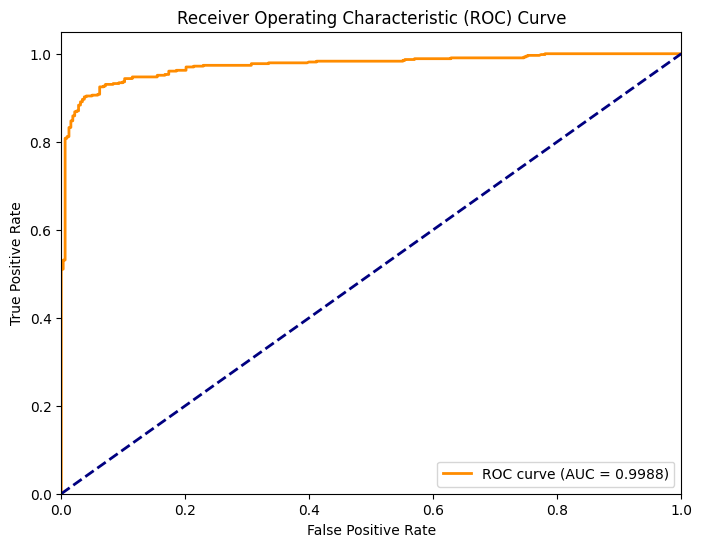

In [27]:
import matplotlib.pyplot as plt

# 이전에 계산된 fpr, tpr, auc 변수를 사용합니다.
# auc 값은 소수점 넷째 자리까지만 표시합니다.
auc_formatted = f"{auc:.4f}"

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_formatted})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 50% 성능의 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# --- 그래프를 이미지 파일로 저장 ---
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
#import joblib
#joblib.dump(model, 'credit_model.pkl')